<a href="https://colab.research.google.com/github/SecretServicess/IBM-PROJECT/blob/main/IBM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements
- Python 3
- PyTorch tested on 1.4.0
- json
- PIL
- skimage
- tqdm
- numpy
- cv2

## Clone IBM- PROJECT Repository

In [ ]:
!git clone https://github.com/SecretServicess/IBM-PROJECT.git

Cloning into 'IBM-PROJECT'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 166 (delta 22), reused 0 (delta 0), pack-reused 95
Receiving objects: 100% (166/166), 463.37 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (41/41), done.


## Configure input data

/content/IBM-PROJECT/sample_images


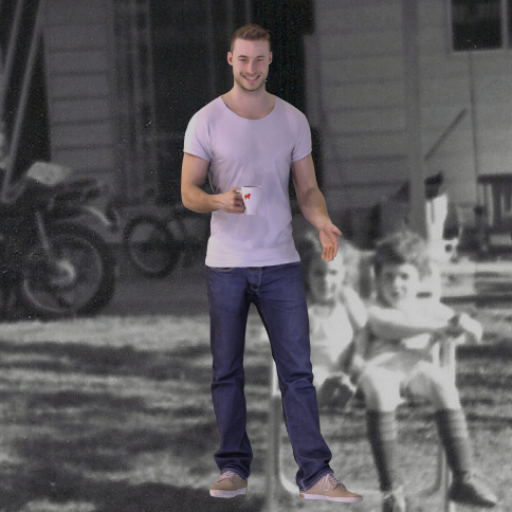

In [ ]:
# Change directory to the specified path
%cd /content/IBM-PROJECT/sample_images

# Import the Image class from IPython.display
from IPython.display import Image

# Display an image
Image(filename='test.png')


In [ ]:
from google.colab import files

filename = list(files.upload().keys())[0]

**If you want to upload your own picture, run the next cell**. Otherwise, go to the next next cell. Currently PNG, JPEG files are supported.

In [ ]:
import os

try:
  image_path = '/content/IBM-PROJECT/sample_images/%s' % filename
except:
  image_path = '/content/IBM-PROJECT/sample_images/test.png' # example image
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/IBM-PROJECT/results/IBM-PROJECT_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/IBM-PROJECT/results/IBM-PROJECT_final/recon/result_%s_256.png' % file_name
video_path = '/content/IBM-PROJECT/results/IBM-PROJECT/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/IBM-PROJECT/results/IBM-PROJECT_final/result_%s_256_display.mp4' % file_name

In [ ]:
cd /content

/content


## Preprocess (for cropping image)

In [ ]:
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git

Cloning into 'lightweight-human-pose-estimation.pytorch'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 120 (delta 19), reused 18 (delta 18), pack-reused 90
Receiving objects: 100% (120/120), 226.05 KiB | 1.14 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
cd /content/lightweight-human-pose-estimation.pytorch/

/content/lightweight-human-pose-estimation.pytorch


In [ ]:
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

--2023-09-01 05:52:07--  https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth
Resolving download.01.org (download.01.org)... 104.115.220.47, 2600:1417:76:79d::4b21, 2600:1417:76:79a::4b21
Connecting to download.01.org (download.01.org)|104.115.220.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87959810 (84M) [application/octet-stream]
Saving to: ‘checkpoint_iter_370000.pth’

checkpoint_iter_370 100%[===================>]  83.88M   237MB/s    in 0.4s    

2023-09-01 05:52:08 (237 MB/s) - ‘checkpoint_iter_370000.pth’ saved [87959810/87959810]



In [ ]:
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)

            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

In [ ]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

## Download the Pretrained Model

In [ ]:
cd /content/IBM-PROJECT/

/content/IBM-PROJECT


In [ ]:
!sh ./scripts/download_trained_model.sh

+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2020-09-19 01:18:11--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt’

pifuhd.pt           100%[===================>]   1.44G  81.3MB/s    in 21s     

2020-09-19 01:18:33 (71.7 MB/s) - ‘pifuhd.pt’ saved [1548375177/1548375177]

--2020-09-19 01:18:33--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: Name or service not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2020-09-19 01:18:33--
Total wall clock time: 21s
Downloaded: 1 files, 1.4G in 21s (71.7 MB/s)


## Run IBM-PROJECT


In [ ]:
# Warning: all images with the corresponding rectangle files under -i will be processed.
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

# seems that 256 is the maximum resolution that can fit into Google Colab.
# If you want to reconstruct a higher-resolution mesh, please try with your own machine.

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/content/IBM-PROJECT/apps/simple_test.py", line 30, in <module>
    reconWrapper(cmd, args.use_rect)
  File "/content/IBM-PROJECT/apps/recon.py", line 220, in reconWrapper
    recon(opt, use_rect)
  File "/content/IBM-PROJECT/apps/recon.py", line 163, in recon
    raise Exception('failed loading state dict!', state_dict_path)
Exception: ('failed loading state dict!', './checkpoints/pifuhd.pt')


## Render the result

In [ ]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

In [ ]:
from lib.colab_util import generate_video_from_obj, set_renderer, video

renderer = set_renderer()
generate_video_from_obj(obj_path, out_img_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)